<a href="https://colab.research.google.com/github/naga8199/CMPE257-Fall23-NagaLakshmi-Nagubandi/blob/homework-2/HW2_Task2_Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np

def generate_ring(N, r1, r2, diffx, diffy, max_v=10000):
    # Generate random numbers between 0 and 1
    zero_to_one_points = np.random.randint(max_v, size=(N, 2)) / (max_v - 1)

    # Generate random numbers in a ring between r1 and r2
    radiuses = r1 + (r2 - r1) * zero_to_one_points[:, 0:1]
    radians = 2.0 * math.pi * zero_to_one_points[:, 1:2]

    # Calculate x and y coordinates
    xs = radiuses * np.cos(radians)
    ys = radiuses * np.sin(radians)

    # Assign signs and move bottom half of the ring
    signs = np.ones(len(xs))
    for idx, rad in enumerate(radians):
        if rad > math.pi and rad < 2*math.pi:
            xs[idx] += diffx
            ys[idx] += diffy
            signs[idx] = -1

    return xs, ys, signs


In [2]:
def linear_regression(X, y):
    """
    Perform linear regression to find the best fit line for the given data.
    The formula used to calculate the weights is:
    w = (X^T * X)^-1 * X^T * y
    """
    # Calculate transpose of X
    XT = np.transpose(X)
    # Calculate inverse of (X^T * X)
    x_inv = np.linalg.inv(np.matmul(XT, X))
    # Calculate weights
    w = np.matmul(np.matmul(x_inv, XT), y)
    return w

In [3]:
import matplotlib.pyplot as plt

def plot_data_and_hypotheses(df, xs, hypotheses, descriptions):
    """
    Plot data points and hypotheses.
    """

    # Separate positive and negative data points
    positive_points = df.loc[df['y'] == 1]
    negative_points = df.loc[df['y'] == -1]

    # Create a figure and a set of subplots
    figsize = plt.figaspect(1)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Plot positive and negative data points
    ax.scatter(positive_points['x1'].values, positive_points['x2'].values, marker='+', color='b', label='+1 labels')
    ax.scatter(negative_points['x1'].values, negative_points['x2'].values, marker='$-$', color='r', label='-1 labels')

    # Plot each hypothesis
    for weights, description in zip(hypotheses, descriptions):
        normalized_weights = weights / weights[-1]
        ax.plot(xs, -(normalized_weights[0] + normalized_weights[1] * xs), label='Hypothesis: ' + description)

    # Set labels and legend
    ax.set_xlabel("$x_1$", fontsize=11)
    ax.set_ylabel("$x_2$", fontsize=11)
    ax.axis('tight')
    ax.legend(loc='center right', bbox_to_anchor=(2.0, 0.5))
    plt.show()

LP1: Problem 3.1 a and b

Liner regression coefficients:  [ 0.25752647 -0.00952647  0.0784342 ]


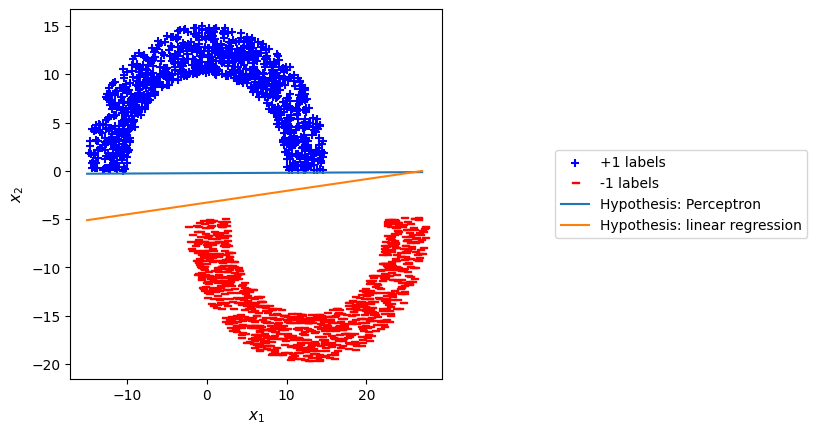

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression

# Parameters
N = 2000  # Number of data points
max_v = 10000  # Maximum value for data generation
rad, thk = 10, 5  # Parameters for generating ring data
sep = 5  # Separation between ring and background
eta = 1  # Learning rate for Perceptron
maxit = 1000  # Maximum number of iterations for Perceptron

# Generate ring data
xs, ys, signs = generate_ring(N, rad, rad+thk, rad + thk/2.0, -sep, max_v)

# Create a DataFrame from the generated data
df = pd.DataFrame({'x1': xs.flatten(), 'x2': ys.flatten(), 'y': signs.flatten()})
df['x0'] = 1
df = df[['x0', 'x1', 'x2', 'y']]

# Prepare data for Perceptron and Linear Regression
X = df[['x0', 'x1', 'x2']].values
y = df['y'].values

# Fit Perceptron model
clf = Perceptron(max_iter=maxit, eta0=eta, shuffle=False)
clf.fit(X, y)
norm_g = clf.coef_[0]

# Prepare data for Linear Regression
w_lin = linear_regression(X,y)
print('Liner regression coefficients: ', w_lin)

# Plot the final hypothesis for Perceptron
x1 = np.arange(-(rad+thk), (rad+thk)+rad + thk/2)
plot_data_and_hypotheses(df, x1, [norm_g, w_lin], ['Perceptron', 'linear regression'])

from the above graphs we can see that PLA and Linear Regression achieves a close solution, though there is a slight difference but we have achieved a hyperplane that can sepearte the points

LP2: Problem 3.3 a - c

If we set sep = -5, that means the points are not separable by a line. If we run PLA on those examples, the PLA algorithm will never stop.

In [5]:
def calculate_error(weights, x, y):
    # Initialize count of misclassifications
    misclassification_count = 0
    # For each data point
    for feature_vector, label in zip(x, y):
        # Calculate the product of the transpose of weights and feature_vector times label
        product = np.dot(weights.T, feature_vector) * label
        # If product is less than 0, increment misclassification_count
        if product < 0:
            misclassification_count += 1
    # Calculate error rate
    error_rate = misclassification_count / len(y)
    return error_rate

In [6]:
def pocket_algo(points, dim, max_it=100, eta=1):
    """
    Implements the Pocket Algorithm for binary classification using the Perceptron Learning Algorithm (PLA).

    Args:
        points (numpy.ndarray): Input data points. Each row contains features followed by the label.
        dim (int): Number of features.
        max_it (int, optional): Maximum number of iterations. Default is 100.
        eta (float, optional): Learning rate. Default is 1.

    Returns:
        w (numpy.ndarray): Final weight vector after iterations.
        w_ts (numpy.ndarray): Array containing the in-sample error at each iteration.
        sample_err (float): Final in-sample error rate.

    Formula:
        Perceptron Model Prediction:
            s_t = w^T * x_t
            where w is the weight vector and x_t is the feature vector of data point t.

        Perceptron Update Rule (if y_t * s_t <= 0):
            w <- w + eta * y_t * x_t
            where eta is the learning rate, y_t is the true label, and s_t is the predicted label for data point t.

        In-Sample Error Calculation:
            in_sample_err = (1 / N) * sum_{n=1}^{N} ln(1 + e^(-y_n * w^T * x_n))
            where N is the number of data points, y_n is the true label, x_n is the feature vector, and w is the weight vector.
    """
    w = np.zeros(dim+1)  # Initialize weight vector with zeros.
    xs, ys = points[:,:dim+1], points[:,dim+1]  # Separate features and labels.
    num_points = points.shape[0]  # Number of data points.
    sample_err = math.inf  # Initialize sample error to infinity.
    w_is = np.zeros(max_it)  # Array to store in-sample error at each iteration.
    wp = w  # Pocket vector to keep track of the best weight vector.

    for i in range(max_it):  # Iterate for a maximum of max_it times.
        idxs = np.arange(num_points)  # Create an array of indices from 0 to num_points-1.

        for idx in idxs:  # Iterate through data points in the order.
            x, y = xs[idx], ys[idx]  # Get the features and label for the current data point.
            st = np.dot(wp.T, x)  # Calculate the dot product of w_h and x.
            prod = st * y  # Calculate the product of st and y.

            if prod <= 0:  # If the product is less than or equal to 0, there is a misclassification.
                wp = wp + eta * y * x  # Update the pocket vector using the PLA update rule.
                break  # Break out of the loop to continue with the next iteration.

        in_sample_err = calculate_error(wp, xs, ys)  # Calculate the in-sample error with the updated pocket vector.
        w_is[i] = in_sample_err  # Store the in-sample error for this iteration.

        if in_sample_err < sample_err:  # If the in-sample error is lower than the best seen so far.
            w = wp  # Update the final weight vector.
            sample_err = in_sample_err  # Update the best sample error.

    w = w / w[-1]  # Normalize the weight vector.
    return w, w_is, sample_err


Pocket algorithm time:  435.9153699874878
final Error Rate:  0.098
final normalized w: [ 0.         -0.21447719  1.        ]
Linear Regression time:  0.0031354427337646484
Linear regression coefficients:  [-0.11846295 -0.02466337  0.10023629]


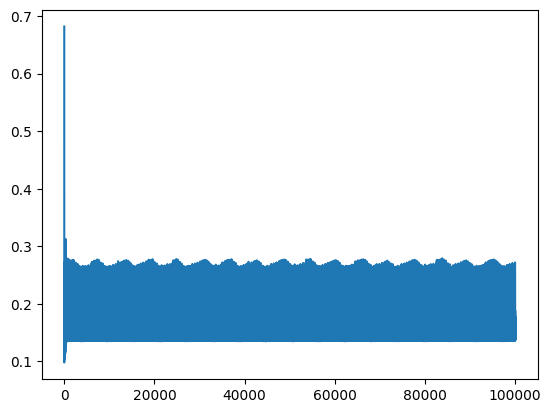

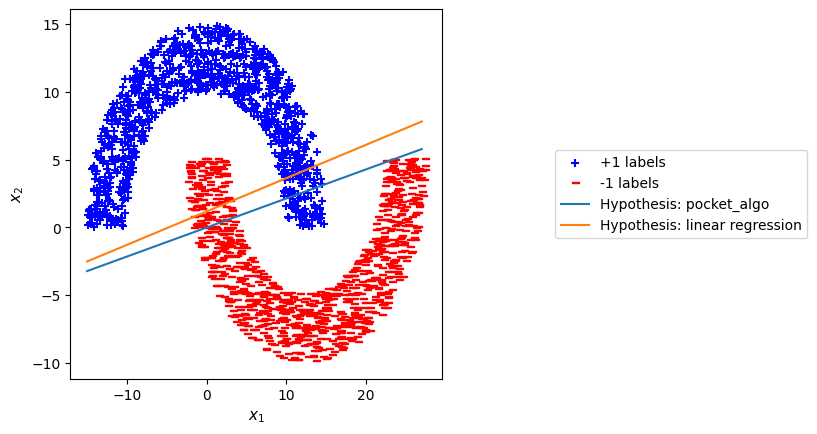

In [7]:
import time

# Set parameters
N = 2000
max_v = 10000
rad, thk = 10, 5
eta = 1
maxit = 100000
dim = 2
sep = -5

# Generate data in a ring shape and create a DataFrame
xs, ys, signs = generate_ring(N, rad, rad+thk, rad + thk/2.0, -sep, max_v)
df = pd.DataFrame({'x1':xs.flatten(), 'x2':ys.flatten(), 'y':signs.flatten()})
df['x0'] = 1
df = df[['x0','x1','x2','y']]

# Run the pocket algorithm and measure its time
start = time.time()
w_pocket, w_is, sample_error = pocket_algo(df.values, dim, maxit, eta)
end = time.time()
print("Pocket algorithm time: ", end-start)
print('final Error Rate: ', sample_error)  # Print the final in-sample error rate.
print('final normalized w:', w_pocket)  # Print the final normalized weight vector.

# Plot E_in vs Iteration number
plt.plot(w_is)

# Run linear regression and measure its time
start = time.time()
w_lin = linear_regression(df[['x0','x1','x2']].values, df['y'].values)
end = time.time()
print("Linear Regression time: ", end-start)
print('Linear regression coefficients: ', w_lin)

# Plot the data and the hypotheses
xs = np.arange(-(rad+thk), (rad+thk)+rad + thk/2)
plot_data_and_hypotheses(df, xs, [w_pocket, w_lin], ['pocket_algo', 'linear regression'])


It takes much much longer to run pocket algorithm than linear regression. This is because at each iteration we need to recompute the in sample error in pocket algorithm.

The quality of pocket solution seems to be better than linear regression though. It has less mis-classified points.

HP1

Pocket algorithm time:  431.32881593704224
Linear Regression time:  0.003199338912963867


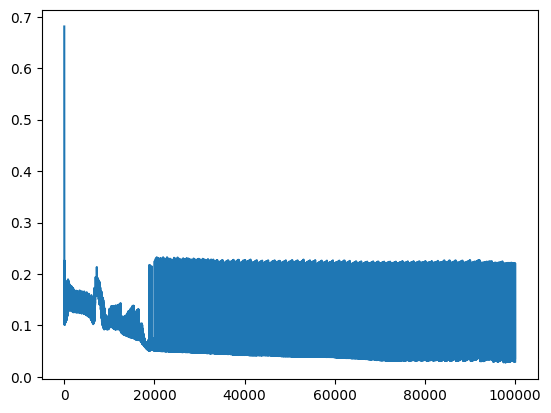

In [8]:
def polynomial_transformation(df):
    """
    Perform a polynomial transformation on the data.

    Parameters:
    df (pandas.DataFrame): A DataFrame where each row is a data point. The 'x1' and 'x2' columns contain the features, and the 'y' column contains the labels.

    Returns:
    df (pandas.DataFrame): The DataFrame after the polynomial transformation. New columns are added for each term in the polynomial.

    This function performs a polynomial transformation on the data in 'df'. It adds new columns for each term in the polynomial up to degree 3.
    """

    # Perform polynomial transformation
    df['x1x2'] = df['x1'] * df['x2']
    df['x1_sq'] = df['x1'] ** 2
    df['x2_sq'] = df['x2'] ** 2
    df['x2x1_sq'] = df['x2'] * df['x1_sq']
    df['x1x2_sq'] = df['x1'] * df['x2_sq']
    df['x1_cu'] = df['x1'] ** 3
    df['x2_cu'] = df['x2'] ** 3

    # Reorder columns
    df = df[['x0', 'x1', 'x2', 'x1x2', 'x1_sq', 'x2_sq', 'x1x2_sq', 'x2x1_sq', 'x1_cu', 'x2_cu', 'y']]

    return df

# Perform polynomial transformation on the data
df_poly = polynomial_transformation(df)
dim_poly = 9

# Run the pocket algorithm and measure its time
start = time.time()
w_pocket, w_is, sample_error = pocket_algo(df_poly.values, dim_poly, maxit, eta)
end = time.time()
print("Pocket algorithm time: ", end-start)

# Plot the E_in vs Iterations
plt.plot(w_is)

# Run linear regression and measure its time
start = time.time()
w_lin = linear_regression(df_poly[['x0','x1','x2', 'x1x2', 'x1_sq', 'x2_sq',
                                   'x1x2_sq', 'x2x1_sq', 'x1_cu', 'x2_cu']].values,
                          df_poly['y'].values)
end = time.time()
print("Linear Regression time: ", end-start)

In [9]:
def find_polynomial_roots(xs, w):
    """
    Find the roots of a polynomial for each x in xs.

    Parameters:
    xs (numpy.ndarray): A 1D numpy array of x values.
    w (numpy.ndarray): A 1D numpy array of weights for the polynomial.

    Returns:
    x2s1, x2s2, x2s3 (list of float): Lists of roots of the polynomial for each x in xs.

    This function calculates the roots of a polynomial with weights 'w' for each x in 'xs'. It returns three lists of roots. If a root is complex, it is replaced with a real root.
    """

    # Initialize lists for roots
    x2s1, x2s2, x2s3 = [], [], []

    # For each x in xs
    for x in xs:
        # Get coefficients of the polynomial
        coeffs = [w[9], w[6]*x+w[5], w[7]*x**2+w[3]*x+w[2], w[8]*x**3+w[4]*x**2+w[1]*x+w[0]]

        # Find roots of the polynomial
        roots = np.roots(coeffs)

        # If a root is complex, replace it with a real root
        r1, r2, r3 = roots
        if np.iscomplex(roots[0]):
            if np.iscomplex(roots[1]):
                r1 = r3
                r2 = r3
            elif np.iscomplex(roots[2]):
                r1 = r2
                r3 = r2
        elif np.iscomplex(roots[1]):
            r2 = r1
            r3 = r1

        # Append roots to lists
        x2s1.append(r1)
        x2s2.append(r2)
        x2s3.append(r3)

    return x2s1, x2s2, x2s3


In [10]:
def plot_data_and_polynomial_hypotheses(w):


    xs = np.arange(-(rad+thk), (rad+thk)+rad + thk/2, 0.1)

    # Separate positive and negative data points
    positives = df_poly.loc[df_poly['y'] == 1]
    negatives = df_poly.loc[df_poly['y'] == -1]

    # Create a figure and a set of subplots
    figsize = plt.figaspect(1)
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Plot positive and negative data points
    ax.scatter(positives['x1'].values, positives['x2'].values, marker='+', color='b', label='+1 labels')
    ax.scatter(negatives['x1'].values, negatives['x2'].values, marker='$-$', color='r', label='-1 labels')

    labels= ['Hypothesis: root1',
         'Hypothesis: root2',
         'Hypothesis: root3']

    # Find roots of the polynomial for each x in xs
    x2s1, x2s2, x2s3 = find_polynomial_roots(xs, w)

    # Plot roots
    ax.plot(xs, x2s1, marker='.', markersize='2', color='g', linestyle="")
    ax.plot(xs, x2s2, marker='.', markersize='2', color='y', linestyle="")
    ax.plot(xs, x2s3, marker='.', markersize='2', color='c', linestyle="")

    # Set labels and legend
    ax.set_xlabel("$x_1$", fontsize=11)
    ax.set_ylabel("$x_2$", fontsize=11)
    ax.legend(['+1 labels', '-1 labels']+labels,
              loc='center right', bbox_to_anchor=(2.0, 0.5))
    plt.show()


Polynomial feature Transform Pocket Algorithm





/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


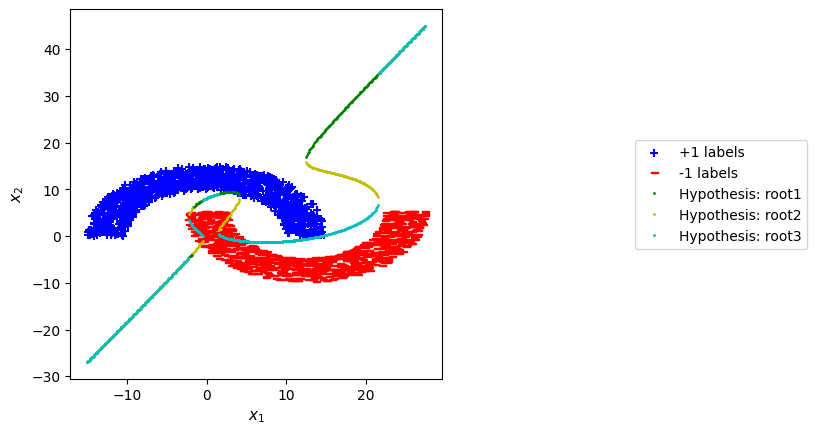

In [11]:
plot_data_and_polynomial_hypotheses(w_pocket)

Polynomial feature Transform Linear Regression


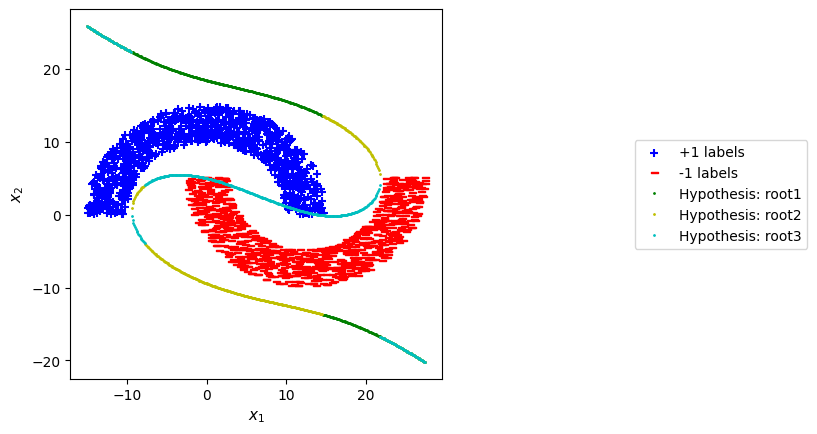

In [12]:
plot_data_and_polynomial_hypotheses(w_lin)

TASK 3
LP1

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_data(file_path):

# Initialize empty lists to store labels and image data
  labels = []
  images = []

# Open and read the file
  with open(file_path, 'r') as file:
    for line in file:

      # Split each line into values based on whitespace
      values = line.strip().split()

      # The first value is the label, and the rest are image data
      label = float(values[0])
      image_data = [float(x) for x in values[1:]]

      # Append label and image data to their respective lists
      labels.append(label)
      images.append(image_data)

# Create a DataFrame with labels as the first column
      df = pd.DataFrame({'Label': labels})

# Add the image data columns to the DataFrame
    for i in range(len(images[0])):
      df[i+1] = [row[i] for row in images]

    return df

In [16]:
df_train=read_data("/content/ZipDigits (2).train")
df_test=read_data("/content/ZipDigits (1).test")

In [17]:
df_train

,Label,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,6.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.631,0.862,...,0.304,0.823,1.000,0.482,-0.474,-0.991,-1.000,-1.000,-1.000,-1.0
1,5.0,-1.0,-1.0,-1.0,-0.813,-0.671,-0.809,-0.887,-0.671,-0.853,...,-0.671,-0.671,-0.033,0.761,0.762,0.126,-0.095,-0.671,-0.828,-1.0
2,4.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-0.109,1.000,-0.179,-1.000,-1.000,-1.000,-1.0
3,7.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.273,0.684,0.960,0.450,...,-0.318,1.000,0.536,-0.987,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
4,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.928,-0.204,0.751,0.466,...,0.466,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7286,3.0,-1.0,-1.0,-1.0,-0.988,-0.527,-0.208,0.620,1.000,0.467,...,-0.116,0.899,0.416,-0.510,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
7287,3.0,-1.0,-1.0,-1.0,-0.990,0.708,0.557,0.347,-0.107,-0.758,...,0.697,0.636,0.167,-0.968,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0
7288,3.0,-1.0,-1.0,-1.0,-0.783,-0.984,-0.827,0.068,1.000,1.000,...,0.805,1.000,1.000,0.727,-0.342,-0.933,-1.000,-1.000,-1.000,-1.0
7289,0.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.549,0.463,0.999,0.999,...,-0.231,0.621,0.999,-0.042,-0.231,-0.687,-1.000,-1.000,-1.000,-1.0


In [18]:
df_test

,Label,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,9.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.948,-0.561,0.148,0.384,...,-1.000,-0.908,0.430,0.622,-0.973,-1.000,-1.0,-1.0,-1.0,-1.0
1,6.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2,3.0,-1.0,-1.0,-1.0,-0.593,0.700,1.000,1.000,1.000,1.000,...,1.000,0.717,0.333,0.162,-0.393,-1.000,-1.0,-1.0,-1.0,-1.0
3,6.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
4,6.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-1.000,-0.858,-0.106,...,0.901,0.901,0.901,0.290,-0.369,-0.867,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,3.0,-1.0,-1.0,-1.0,-1.000,-1.000,-0.417,0.814,1.000,0.775,...,1.000,1.000,0.554,0.184,-0.484,-1.000,-1.0,-1.0,-1.0,-1.0
2003,9.0,-1.0,-1.0,-1.0,-1.000,-1.000,-1.000,-0.855,0.209,0.941,...,-1.000,0.319,1.000,0.056,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2004,4.0,-1.0,-1.0,-1.0,-1.000,-0.031,0.752,-0.431,-1.000,-1.000,...,1.000,0.928,-0.393,-1.000,-1.000,-1.000,-1.0,-1.0,-1.0,-1.0
2005,0.0,-1.0,-1.0,-1.0,-1.000,-0.534,0.578,1.000,0.301,-0.328,...,1.000,0.430,0.200,-0.061,-0.975,-1.000,-1.0,-1.0,-1.0,-1.0


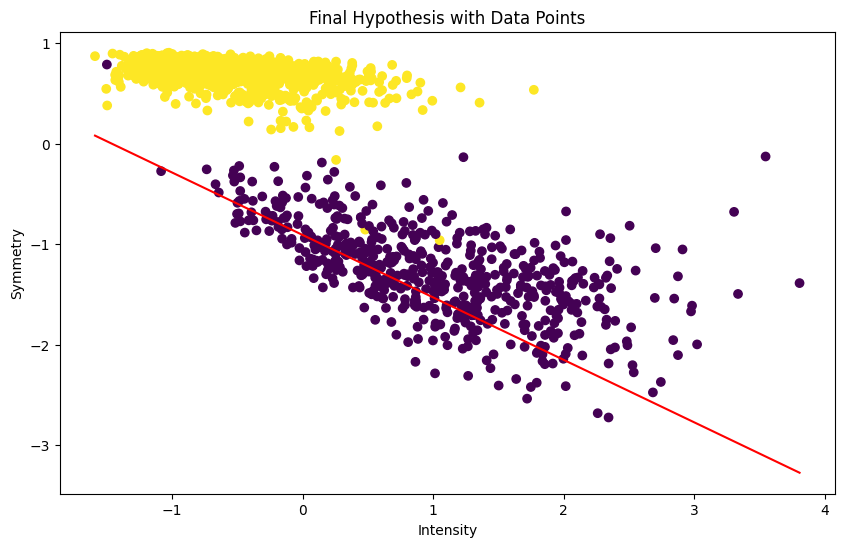

In [19]:
from sklearn.preprocessing import StandardScaler
# Filter the dataset to include only digits labeled as '1' and '5'
df = df_train[(df_train.iloc[:, 0] == 1) | (df_train.iloc[:, 0] == 5)]

# Convert the labels into labels for binary classification
df.loc[df.iloc[:, 0] == 1, df.columns[0]] = 1
df.loc[df.iloc[:, 0] == 5, df.columns[0]] = -1

# Extract intensity and symmetry features
intensity = df.iloc[:, 1:].mean(axis=1)
symmetry = -np.abs(df.iloc[:, 1:].values.reshape(-1, 16, 16) - df.iloc[:, 1:].values.reshape(-1, 16, 16)[:, ::-1]).sum(axis=(1,2))
features = np.column_stack((intensity, symmetry))

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Initialize weights and bias
weights = np.zeros(features.shape[1])
bias = 0

# PLA algorithm
for _ in range(1000):
    # Compute predictions
    predictions = np.sign(np.dot(features, weights) + bias)

    # Find misclassified points
    misclassified = np.where(predictions != df.iloc[:, 0].values)[0]

    # If no misclassified points, break
    if len(misclassified) == 0:
        break

    # Randomly choose a misclassified point
    point = np.random.choice(misclassified)

    # Update weights and bias
    weights += df.iloc[point, 0] * features[point]
    bias += df.iloc[point, 0]

# Plotting the final hypothesis along with the data points
plt.figure(figsize=(10,6))
plt.scatter(features[:, 0], features[:, 1], c=df.iloc[:, 0], cmap='viridis')
x_vals = np.linspace(min(features[:, 0]), max(features[:, 0]), 100)
y_vals = -(weights[0]*x_vals + bias)/weights[1]
plt.plot(x_vals, y_vals, color='red')
plt.xlabel('Intensity')
plt.ylabel('Symmetry')
plt.title('Final Hypothesis with Data Points')
plt.show()


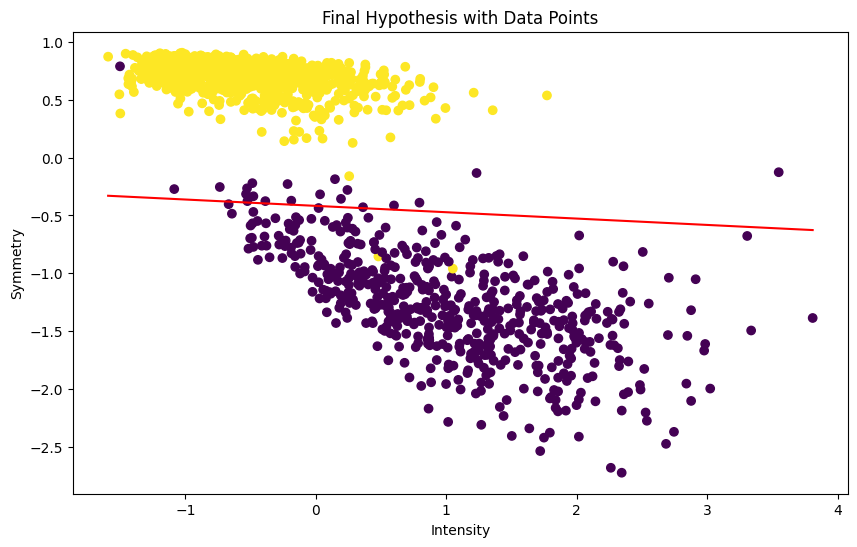

In [20]:
# Filter the dataset to include only digits labeled as '1' and '5'
df = df_train[(df_train.iloc[:, 0] == 1) | (df_train.iloc[:, 0] == 5)]

# Convert the labels into labels for binary classification
df.loc[df.iloc[:, 0] == 1, df.columns[0]] = 1
df.loc[df.iloc[:, 0] == 5, df.columns[0]] = -1

# Extract intensity and symmetry features
intensity = df.iloc[:, 1:].mean(axis=1)
symmetry = -np.abs(df.iloc[:, 1:].values.reshape(-1, 16, 16) - df.iloc[:, 1:].values.reshape(-1, 16, 16)[:, ::-1]).sum(axis=(1,2))
features = np.column_stack((intensity, symmetry))

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Initialize weights and bias for PLA and Pocket algorithm
weights = np.zeros(features.shape[1])
bias = 0

# Initialize weights and bias for the best solution (pocket)
best_weights = np.zeros(features.shape[1])
best_bias = 0
best_error = np.inf

# Pocket algorithm with PLA updates
for _ in range(1000):
    # Compute predictions
    predictions = np.sign(np.dot(features, weights) + bias)

    # Find misclassified points
    misclassified = np.where(predictions != df.iloc[:, 0].values)[0]

    # If no misclassified points, break
    if len(misclassified) == 0:
        break

    # Randomly choose a misclassified point
    point = np.random.choice(misclassified)

    # Update weights and bias
    weights += df.iloc[point, 0] * features[point]
    bias += df.iloc[point, 0]

    # Compute error
    error = len(misclassified)

    # If this solution is better than the one in the pocket, update the pocket
    if error < best_error:
        best_error = error
        best_weights = weights.copy()
        best_bias = bias

# Plotting the final hypothesis along with the data points using the best solution from the pocket
plt.figure(figsize=(10,6))
plt.scatter(features[:, 0], features[:, 1], c=df.iloc[:, 0], cmap='viridis')
x_vals = np.linspace(min(features[:, 0]), max(features[:, 0]), 100)
y_vals = -(best_weights[0]*x_vals + best_bias)/best_weights[1]
plt.plot(x_vals, y_vals, color='red')
plt.xlabel('Intensity')
plt.ylabel('Symmetry')
plt.title('Final Hypothesis with Data Points')
plt.show()


In [22]:
# Filter the test dataset to include only digits labeled as '1' and '5'
df_test = df_test[(df_test.iloc[:, 0] == 1) | (df_test.iloc[:, 0] == 5)]

# Convert the labels into labels for binary classification
df_test.loc[df_test.iloc[:, 0] == 1, df_test.columns[0]] = 1
df_test.loc[df_test.iloc[:, 0] == 5, df_test.columns[0]] = -1

# Extract intensity and symmetry features
intensity_test = df_test.iloc[:, 1:].mean(axis=1)
symmetry_test = -np.abs(df_test.iloc[:, 1:].values.reshape(-1, 16, 16) - df_test.iloc[:, 1:].values.reshape(-1, 16, 16)[:, ::-1]).sum(axis=(1,2))
features_test = np.column_stack((intensity_test, symmetry_test))

# Normalize features
features_test = scaler.transform(features_test)

# Compute predictions for both PLA and Pocket algorithm
predictions_pla = np.sign(np.dot(features_test, weights) + bias)
predictions_pocket = np.sign(np.dot(features_test, best_weights) + best_bias)

# Compute error rates
error_rate_pla = np.mean(predictions_pla != df_test.iloc[:, 0].values)
error_rate_pocket = np.mean(predictions_pocket != df_test.iloc[:, 0].values)

print(f'Error rate of PLA: {error_rate_pla}')
print(f'Error rate of Pocket Algorithm: {error_rate_pocket}')

Error rate of PLA: 0.041666666666666664
Error rate of Pocket Algorithm: 0.015151515151515152


From the above we can see that pocket algorithm has least error rate and better hypothesis

LP2

The test error is 0.03409090909090909


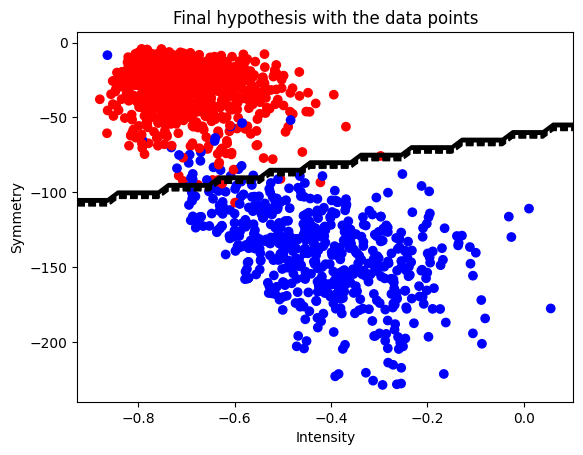

In [24]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define a function to extract intensity and symmetry features from the grayscale image
def extract_features(image):
  # Intensity is the average of the pixel values
  intensity = np.mean(image)
  # Symmetry is the negative absolute difference between the left and right halves of the image
  symmetry = -np.sum(np.abs(image - image[:, ::-1]))
  return intensity, symmetry

# Define a function to transform the features into a third order polynomial
def polynomial_transform(features):
  # The polynomial transformation is [1, x1, x2, x1^2, x1x2, x2^2, x1^3, x1^2x2, x1x2^2, x2^3]
  # where x1 and x2 are the intensity and symmetry features respectively
  x1 = features[:, 0]
  x2 = features[:, 1]
  return np.c_[np.ones(len(features)), x1, x2, x1**2, x1*x2, x2**2, x1**3, x1**2*x2, x1*x2**2, x2**3]

# Define a function to implement the pocket algorithm for binary classification
def pocket_algorithm(X, y, max_updates):
  # Initialize the weight vector randomly
  w = np.random.randn(X.shape[1])
  # Initialize the best weight vector and the best error
  w_best = w.copy()
  e_best = np.inf
  # Loop for max_updates times
  for i in range(max_updates):
    # Predict the labels using the current weight vector
    y_pred = np.sign(X.dot(w))
    # Compute the error as the number of misclassified points
    e = np.sum(y_pred != y)
    # If the error is lower than the best error, update the best weight vector and the best error
    if e < e_best:
      w_best = w.copy()
      e_best = e
    # If the error is zero, break the loop
    if e == 0:
      break
    # Randomly pick one misclassified point and update the weight vector using its feature and label
    mis_idx = np.where(y_pred != y)[0]
    j = np.random.choice(mis_idx)
    w = w + y[j] * X[j]
  # Return the best weight vector and the best error
  return w_best, e_best

# Filter the data to include only digits labeled as '1' and '5'
train_data = df_train[(df_train["Label"] == 1) | (df_train["Label"] == 5)]
test_data = df_test[(df_test["Label"] == 1) | (df_test["Label"] == 5)]

# Convert the labels into labels for binary classification, i.e., '1' and '-1'
train_data["Label"] = train_data["Label"].map({1: 1, 5: -1})
test_data["Label"] = test_data["Label"].map({1: 1, 5: -1})

# Extract intensity and symmetry features from the grayscale images
train_features = np.array([extract_features(train_data.iloc[i, 1:257].values.reshape(16, 16)) for i in range(len(train_data))])
test_features = np.array([extract_features(test_data.iloc[i, 1:257].values.reshape(16, 16)) for i in range(len(test_data))])

# Transform the features into a third order polynomial
train_X = polynomial_transform(train_features)
test_X = polynomial_transform(test_features)

# Get the labels as numpy arrays
train_y = train_data["Label"].values
test_y = test_data["Label"].values

# Run the pocket algorithm for 1000 updates on the training data
w_best, e_best = pocket_algorithm(train_X, train_y, max_updates=1000)

# Report the test error using the best weight vector
y_test_pred = np.sign(test_X.dot(w_best))
e_test = np.sum(y_test_pred != test_y)
print(f"The test error is {e_test / len(test_y)}")

# Plot the resulting final hypothesis with the data points on a scatter plot
plt.scatter(train_features[:, 0], train_features[:, 1], c=train_y, cmap="bwr")
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max), np.linspace(y_min, y_max))
zz = np.sign(polynomial_transform(np.c_[xx.ravel(), yy.ravel()]).dot(w_best))
zz = zz.reshape(xx.shape)
plt.contour(xx, yy, zz, colors="black")
plt.xlabel("Intensity")
plt.ylabel("Symmetry")
plt.title("Final hypothesis with the data points")
plt.show()


References:
Matplotlib 3.8.0 documentation,
Matplotlib Tutorial - W3Schools,
Python Plotting With Matplotlib (Guide) – Real Python